# Modeling COVID-19 Spread and Healthcare Capacity # 

Goal is to predict how many COVID-19 patients they will have to provide in-patient medical care for in the next 3 weeks. This will be achieved by modelling the infection rate. Regions that will not have enough resources to cope with their COVID-19 patients in any given week will be matched to a region that will have a surplus of medical resources that week, so that the burden can be shared and more patients can receive life-saving treatment.

In [108]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from operator import itemgetter
import operator

In [109]:
os.listdir("./")

['.DS_Store',
 'modeling_covics_eindhoven.ipynb',
 'figs',
 'code',
 '.gitmodules',
 'results',
 '.gitignore',
 '.ipynb_checkpoints',
 'modeling_covics.ipynb',
 'data']

In [110]:
data_dir = "../../COVID-19/csse_covid_19_data/"

In [111]:
# Load the start of these datasets
#covid_confirmed.head()
#covid_deaths.head()
#covid_recovered.head()

In [112]:
# Load datasets

covid_confirmed = pd.read_csv(data_dir+'csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_deaths = pd.read_csv(data_dir+'csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid_recovered = pd.read_csv(data_dir+'csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [113]:
# Extract all column names
cols_keys = covid_confirmed.keys()
# Make sure all datasets have the same columns
# Test this code with covid_confirmed = covid_confirmed.drop(['Lat'], axis=1)
lists = [covid_confirmed.keys(), covid_deaths.keys(), covid_recovered.keys()]
it = iter(lists)
the_len = len(cols_keys)
if not all(len(l) == the_len for l in it):
    raise ValueError('not all lists have same length!')

print(f'Total number of days in database: {len(cols_keys)-4}')

Total number of days in database: 68


In [114]:
# Collect the counts for each date
confirmed = covid_confirmed.loc[:, cols_keys[4]:cols_keys[-1]]
deaths = covid_deaths.loc[:, cols_keys[4]:cols_keys[-1]]
recovered = covid_recovered.loc[:, cols_keys[4]:cols_keys[-1]]
dates = confirmed.keys()

In [115]:
# Calculate totals, rates, and cumulative counts in the world
total_confirmed_global = []
total_deaths_global = []
total_recovered_global = []
mortality_rate_global = []
for d in dates:
    tmp_conf = confirmed[d].sum()
    tmp_deat = deaths[d].sum()
    tmp_reco = recovered[d].sum()
    total_confirmed_global.append(tmp_conf)
    total_deaths_global.append(tmp_deat)
    total_recovered_global.append(tmp_reco)
    mortality_rate_global.append(tmp_deat/tmp_conf)


In [116]:
# convert to numpy arrays
days = np.array([i for i in range(len(dates))]).reshape(-1,1)
total_confirmed_global = np.array(total_confirmed_global).reshape(-1,1)
total_deaths_global = np.array(total_deaths_global).reshape(-1,1)
total_recovered_global = np.array(total_recovered_global).reshape(-1,1)

In [117]:
# Exponential growth
def func(x, a, b):
    return a * np.exp(b * x) 
# Fit - but not working
#days2 = np.array([i for i in range(len(dates))]).reshape(1,-1)
#popt, pcov = curve_fit(func, days.ravel(),  total_confirmed.ravel())
#plt.plot(days, total_confirmed, 'b-', days, func(days, *popt), 'g--')
popt = [total_confirmed_global[0],0.1075]

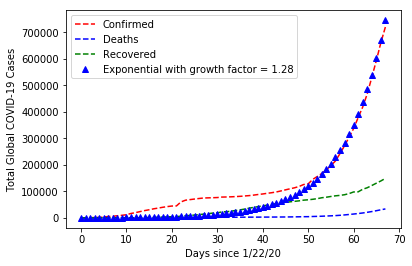

In [118]:
fig, ax = plt.subplots()
ax.plot(days, total_confirmed_global, 'r--', label='Confirmed')
ax.plot(days, total_deaths_global   , 'b--' , label='Deaths')
ax.plot(days, total_recovered_global, 'g--' , label='Recovered')
ax.plot(days, func(days, *popt), 'b^' , label='Exponential with growth factor = %.2f' % 10**popt[1])
plt.legend()
plt.xlabel('Days since %s' % dates[0])
plt.ylabel('Total Global COVID-19 Cases')
plt.show()

In [119]:
# Future forcasting for the next 3 weeks
# dates: actual dates
days_in_future = 21
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1) # days count including future forecasting
adjusted_dates = future_forecast[:-days_in_future] # days count up to now


In [120]:
# Convert all integers into datetime 
import datetime
start = '1/22/2020'
start_date = datetime.datetime.strptime(start,'%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [121]:
# Latest data
latest_confirmed = covid_confirmed[dates[-1]]
latest_deaths = covid_deaths[dates[-1]]
latest_recovered = covid_recovered[dates[-1]]

In [122]:
# List of unique countries
unique_countries = list(covid_recovered['Country/Region'].unique())

In [123]:
# Total number of cases by each country
total_confirmed_by_country = []
total_deaths_by_country = []
total_recovered_by_country = []
mortality_rate_by_country = []
no_cases = []

for i in unique_countries:
    cases_confirmed = latest_confirmed[covid_confirmed['Country/Region']==i].sum()
    cases_deaths = latest_deaths[covid_confirmed['Country/Region']==i].sum()
    cases_recovered = latest_recovered[covid_confirmed['Country/Region']==i].sum()
    #print(i, len(latest_confirmed[covid_confirmed['Country/Region']==i]))
    if cases_confirmed > 0:
        total_confirmed_by_country.append(cases_confirmed)
    else:
        no_cases.append(i)
    if cases_deaths > 0:
        total_deaths_by_country.append(cases_deaths)
    if cases_recovered > 0:
        total_recovered_by_country.append(cases_recovered)

for i in no_cases:
    unique_countries.remove(i)
# Sort based on the number of cases
unique_countries = [k for k,v in sorted(zip(unique_countries, total_confirmed_by_country), key=operator.itemgetter(1), reverse=True) ]
for i in range(len(unique_countries)):
    total_confirmed_by_country[i] = latest_confirmed[covid_confirmed['Country/Region']==unique_countries[i]].sum()

In [124]:
# Print number of cases per country/area
print('Confirmed cases by Countries/Regions')
for i in range(len(unique_countries[:10])):
    print(f'{unique_countries[i]}: {total_confirmed_by_country[i]} cases' )

Confirmed cases by Countries/Regions
US: 140886 cases
Italy: 97689 cases
China: 82122 cases
Spain: 80110 cases
Germany: 62095 cases
France: 40708 cases
Iran: 38309 cases
United Kingdom: 19780 cases
Switzerland: 14829 cases
Netherlands: 10930 cases


In [125]:
# List of unique province/state
unique_states = list(covid_recovered['Province/State'].unique())

In [126]:
# Total number of cases by each province/state
total_confirmed_by_state = []
no_cases = []
for i in unique_states:
    cases_confirmed = latest_confirmed[covid_confirmed['Province/State']==i].sum()
    if cases_confirmed > 0:
        total_confirmed_by_state.append(cases_confirmed)
    else:
        no_cases.append(i)

for i in no_cases:
    unique_states.remove(i)
    
# Print number of cases per country/area
print('Confirmed cases by Province/State')
for i in range(len(unique_states[:10])):
    print(f'{unique_states[i]}: {total_confirmed_by_state[i]} cases' )

Confirmed cases by Province/State
Australian Capital Territory: 77 cases
New South Wales: 1791 cases
Northern Territory: 15 cases
Queensland: 656 cases
South Australia: 299 cases
Tasmania: 66 cases
Victoria: 769 cases
Western Australia: 311 cases
Anhui: 990 cases
Beijing: 577 cases


In [127]:
# handle missing values
nan_indices = []

for i in range(len(unique_states)):
    if type(unique_states[i]) == float:
        nan_indices.append(i)

unique_states = list(unique_states)
total_confirmed_by_state = list(total_confirmed_by_state)

for i in nan_indices:
    unique_states.pop(i)
    total_confirmed_by_state.pop(i)

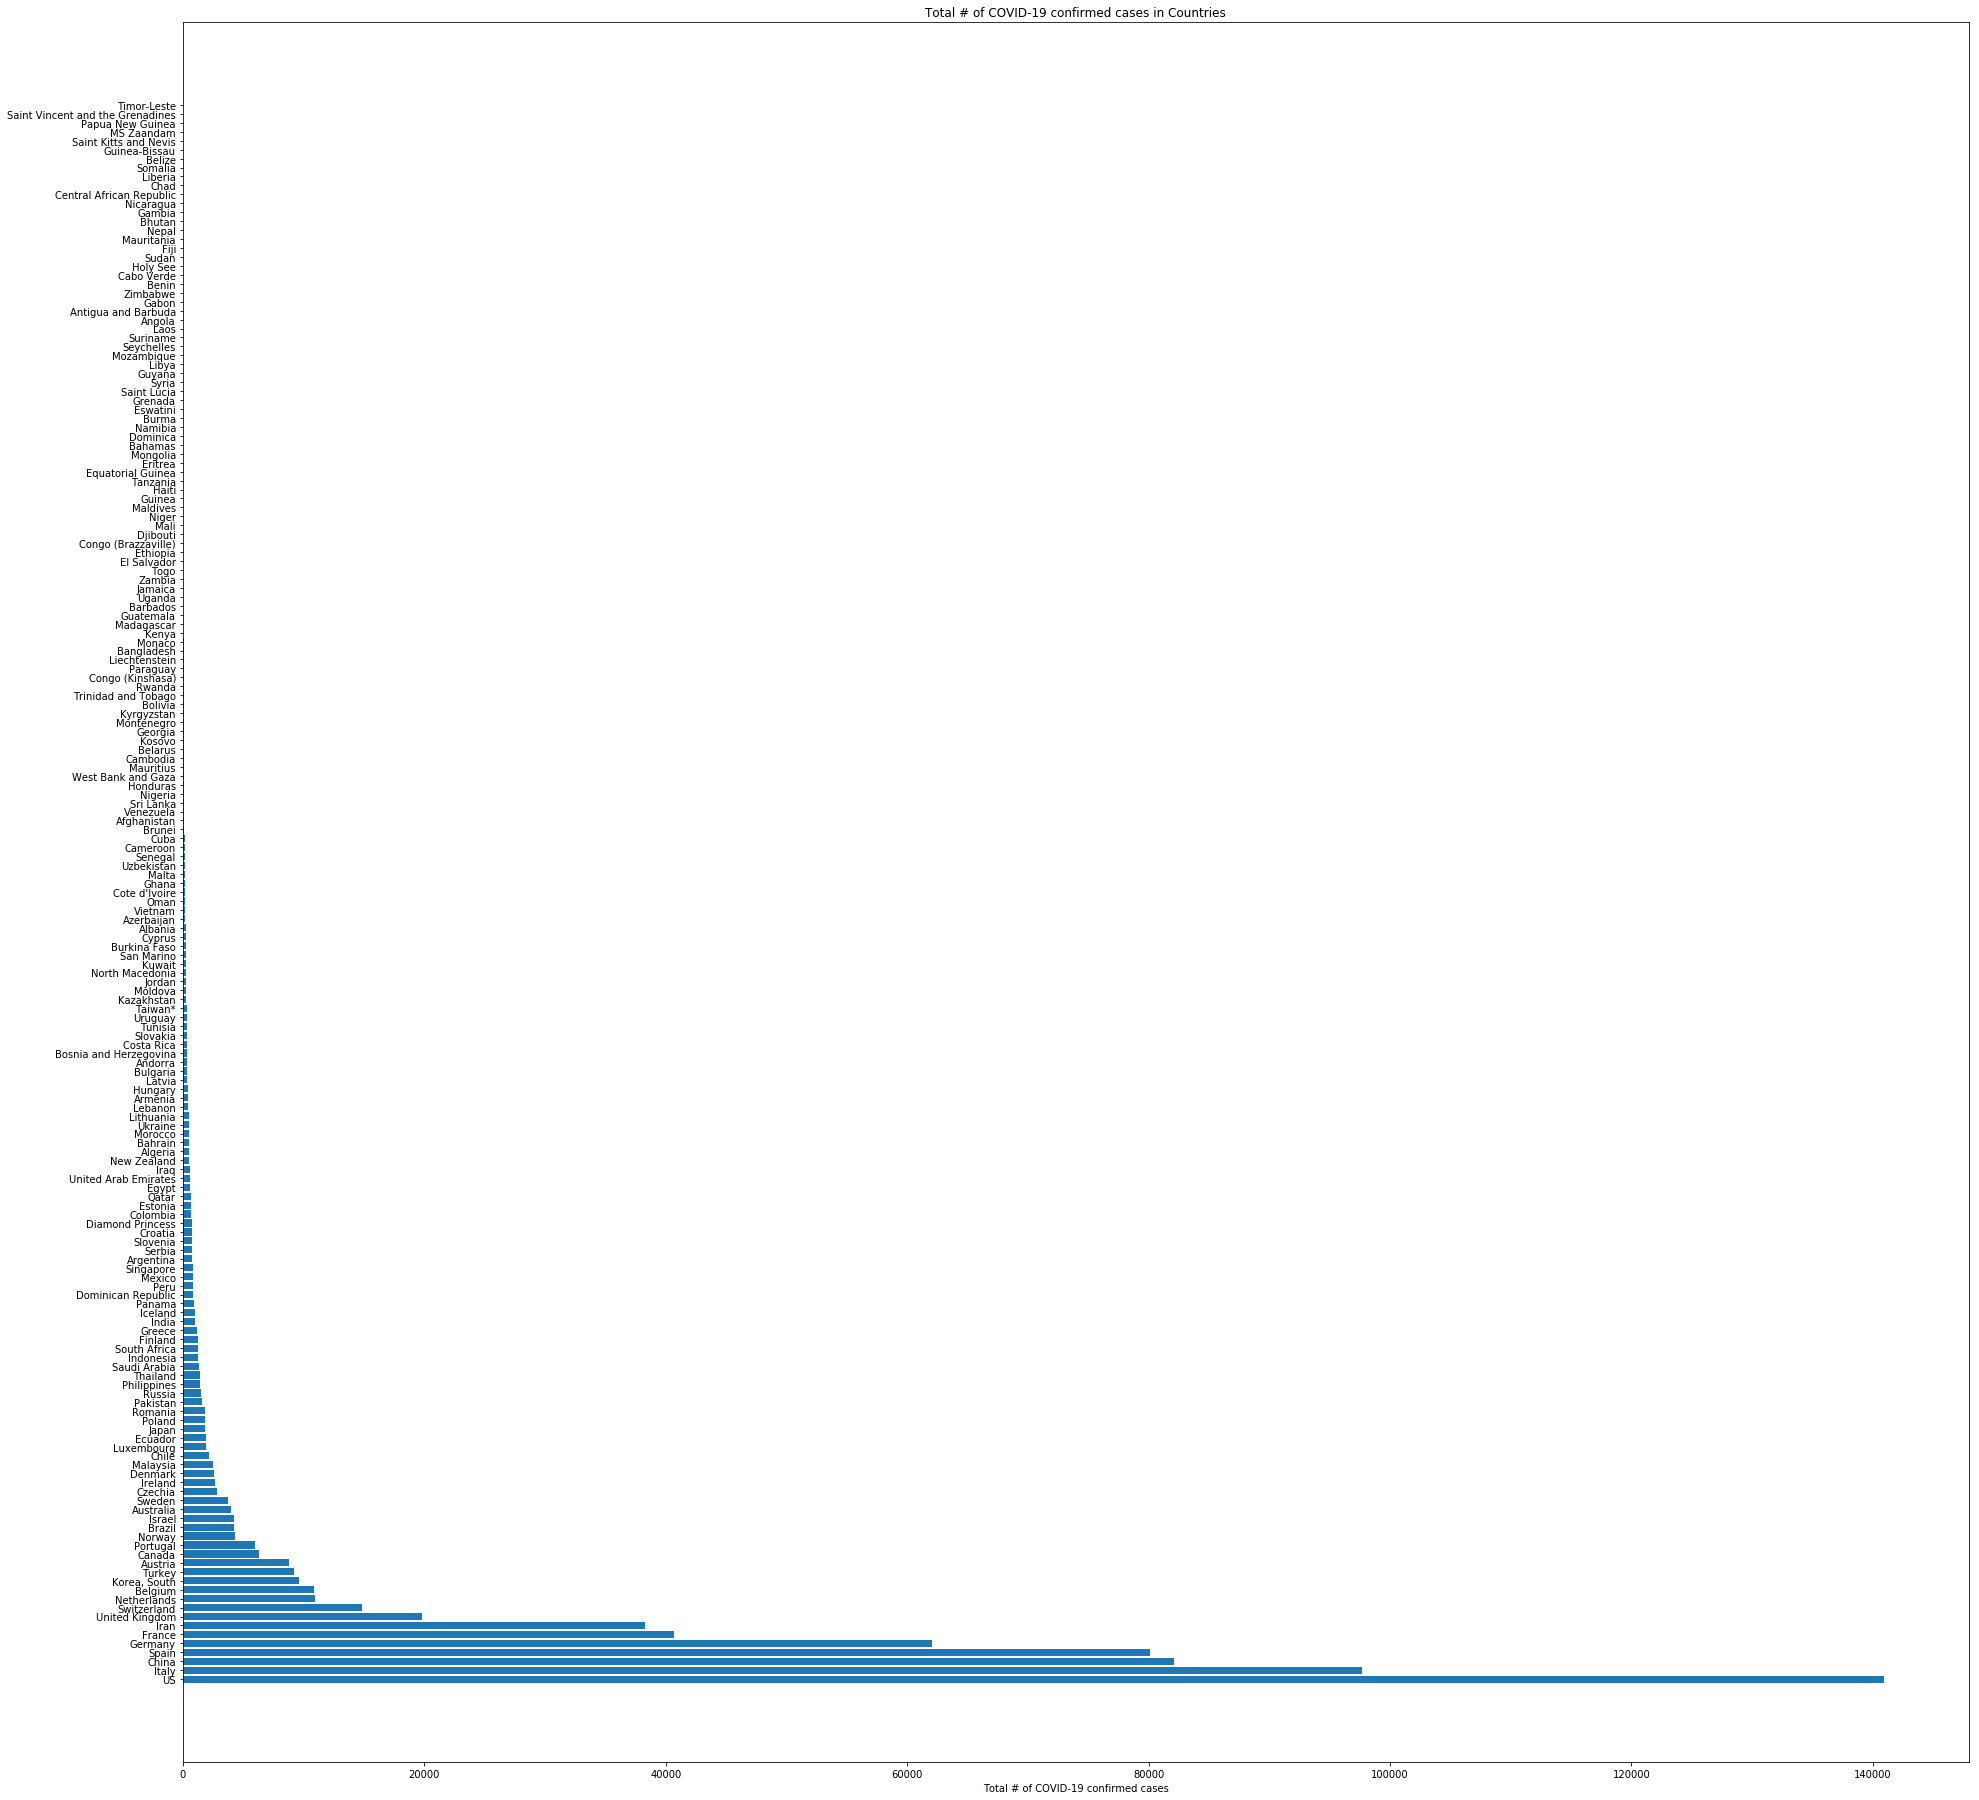

In [128]:
# Some visualization now

plt.figure(figsize=(32,32))
plt.barh(unique_countries, total_confirmed_by_country)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.xlabel("Total # of COVID-19 confirmed cases")
plt.show()

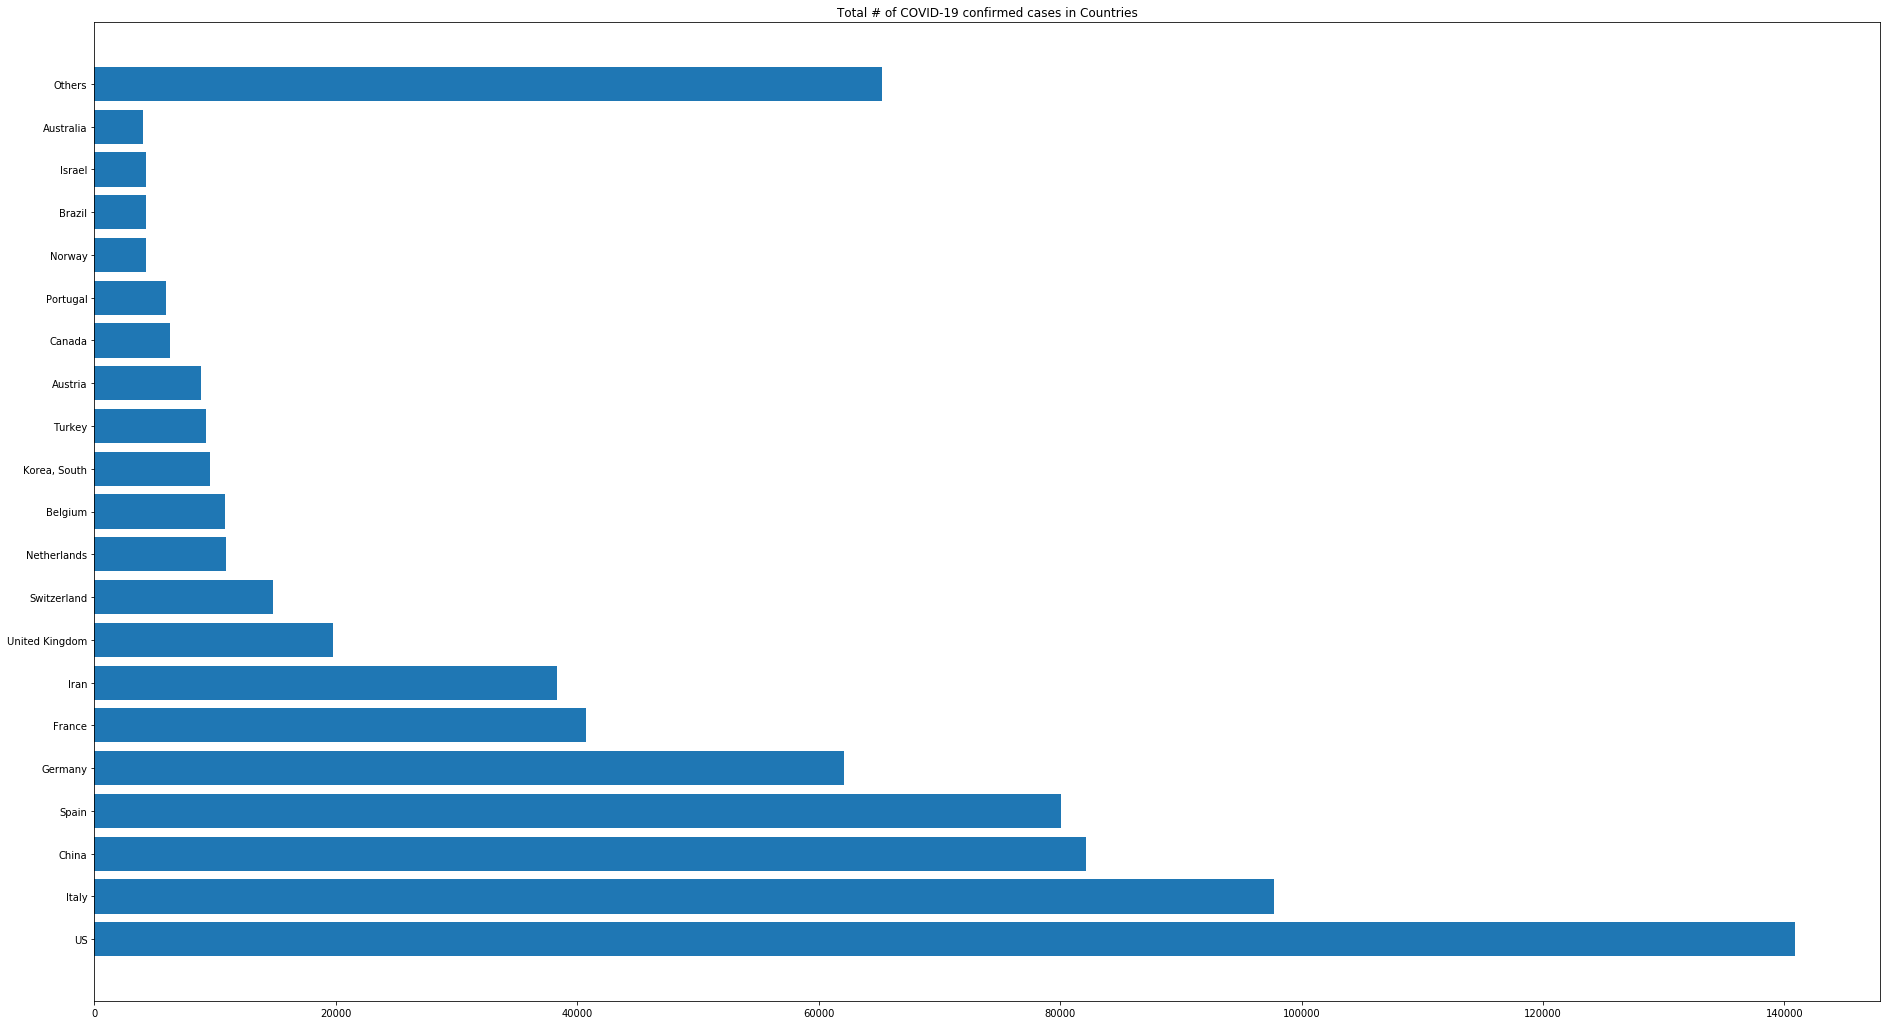

In [129]:
# make it easier to visualize, pick the 10 top cases + other cases
visual_unique_countries = []
visual_confirmed_cases = []
others = np.sum(total_confirmed_by_country[20:])
for i in range(len(total_confirmed_by_country[:20])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(total_confirmed_by_country[i])
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

plt.figure(figsize=(32,18))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.show()

## Fit Hopkins data ## 

In [130]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed infections")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected infections (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected infections (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 140886
	Confirmed cases on 3/22/20 	 33276
	Ratio: 4.23
	Weekly increase: 323.4 %
	Daily increase: 22.9 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.9947601247636948
	Doubling Time (represents overall growth):  3.23 (± 0.12 ) days


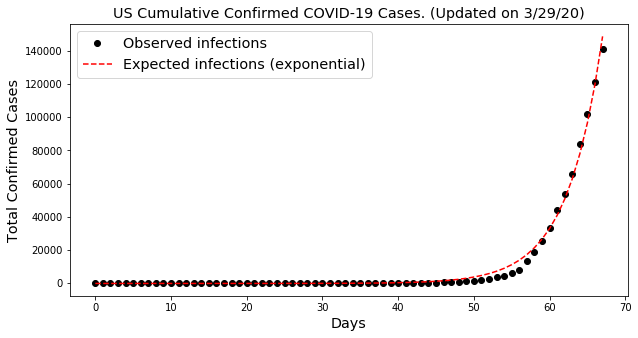



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 97689
	Confirmed cases on 3/22/20 	 59138
	Ratio: 1.65
	Weekly increase: 65.2 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.9995874128650082
	Doubling Time (during middle of growth):  7.51 (± 0.21 ) days

** Based on Exponential Fit **

	R^2: 0.9772435771875994
	Doubling Time (represents overall growth):  5.71 (± 0.5 ) days


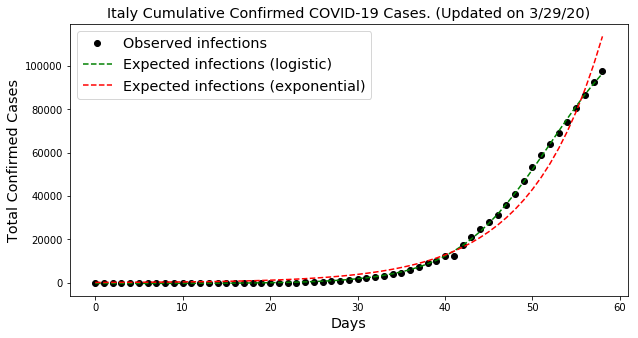



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 82122
	Confirmed cases on 3/22/20 	 81435
	Ratio: 1.01
	Weekly increase: 0.8 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 577.6 days

** Based on Logistic Fit**

	R^2: 0.9957208383381546
	Doubling Time (during middle of growth):  6.51 (± 0.49 ) days


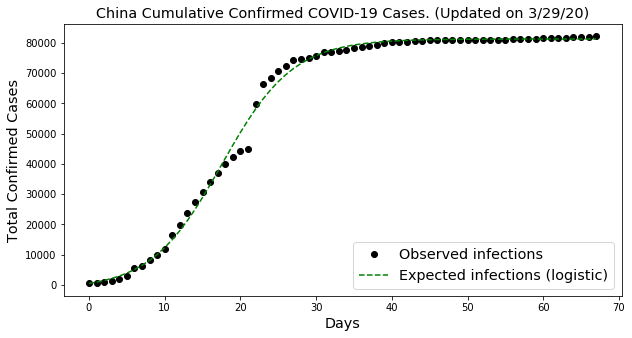



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 80110
	Confirmed cases on 3/22/20 	 28768
	Ratio: 2.78
	Weekly increase: 178.5 %
	Daily increase: 15.8 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9991540535019782
	Doubling Time (during middle of growth):  6.11 (± 0.26 ) days

** Based on Exponential Fit **

	R^2: 0.9933537032704164
	Doubling Time (represents overall growth):  4.37 (± 0.2 ) days


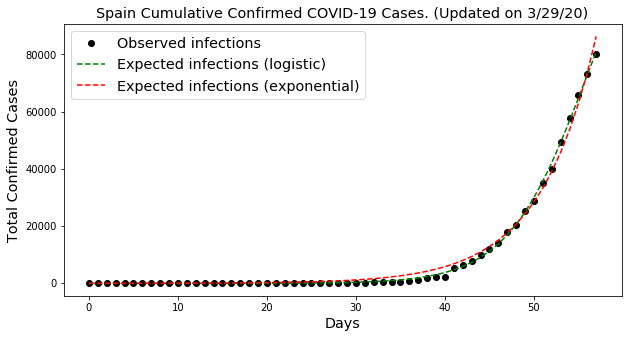



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 62095
	Confirmed cases on 3/22/20 	 24873
	Ratio: 2.5
	Weekly increase: 149.6 %
	Daily increase: 14.0 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9984000711058956
	Doubling Time (during middle of growth):  6.31 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.9921407191926871
	Doubling Time (represents overall growth):  4.58 (± 0.22 ) days


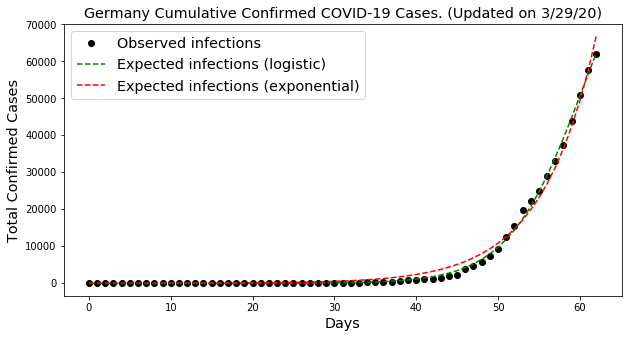

In [131]:
#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
cases = covid_confirmed.iloc[:,[1,-1]].groupby('Country/Region').sum()
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]

topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')




    print(c)
    a = plotCases(covid_confirmed, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3])
    print('\n')

    

## Prediction for the next 3 weeks ## 



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 140886
	Confirmed cases on 3/22/20 	 33276
	Ratio: 4.23
	Weekly increase: 323.4 %
	Daily increase: 22.9 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.9947601247636948
	Doubling Time (represents overall growth):  3.23 (± 0.12 ) days


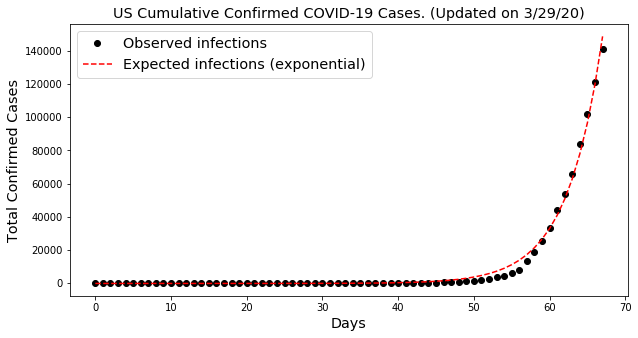

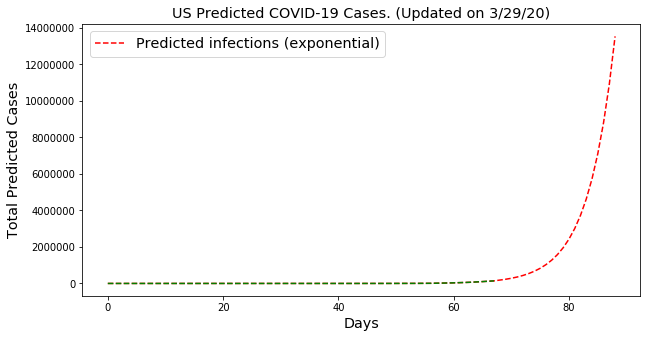



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 97689
	Confirmed cases on 3/22/20 	 59138
	Ratio: 1.65
	Weekly increase: 65.2 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.9995874128650082
	Doubling Time (during middle of growth):  7.51 (± 0.21 ) days

** Based on Exponential Fit **

	R^2: 0.9772435771875994
	Doubling Time (represents overall growth):  5.71 (± 0.5 ) days


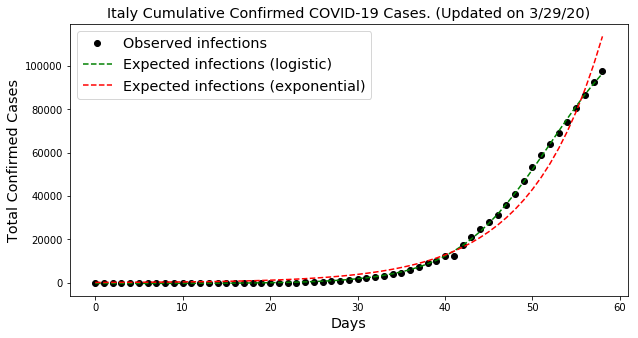

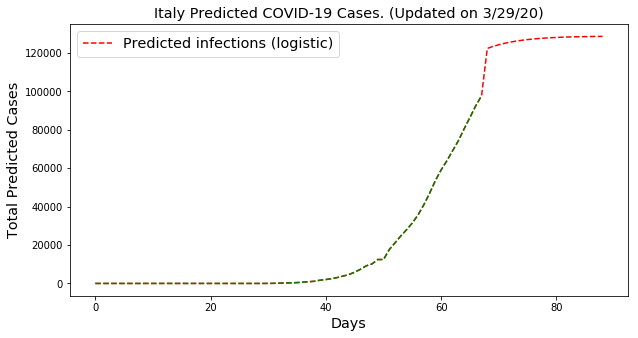



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 82122
	Confirmed cases on 3/22/20 	 81435
	Ratio: 1.01
	Weekly increase: 0.8 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 577.6 days

** Based on Logistic Fit**

	R^2: 0.9957208383381546
	Doubling Time (during middle of growth):  6.51 (± 0.49 ) days


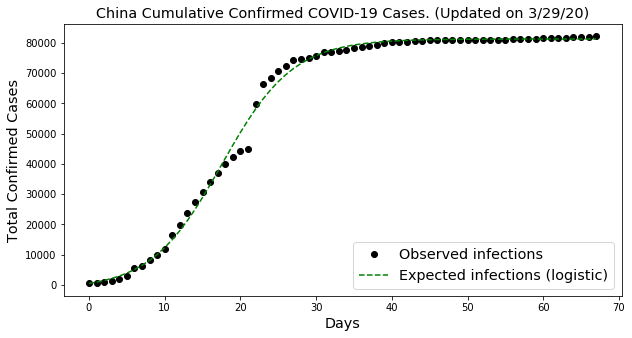

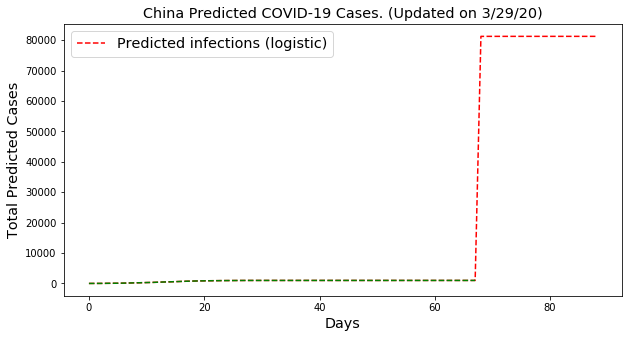



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 80110
	Confirmed cases on 3/22/20 	 28768
	Ratio: 2.78
	Weekly increase: 178.5 %
	Daily increase: 15.8 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9991540535019782
	Doubling Time (during middle of growth):  6.11 (± 0.26 ) days

** Based on Exponential Fit **

	R^2: 0.9933537032704164
	Doubling Time (represents overall growth):  4.37 (± 0.2 ) days


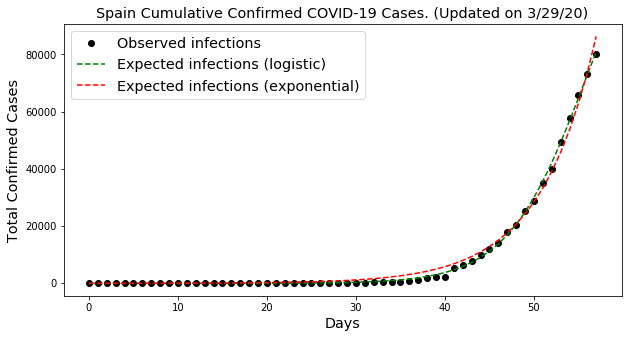

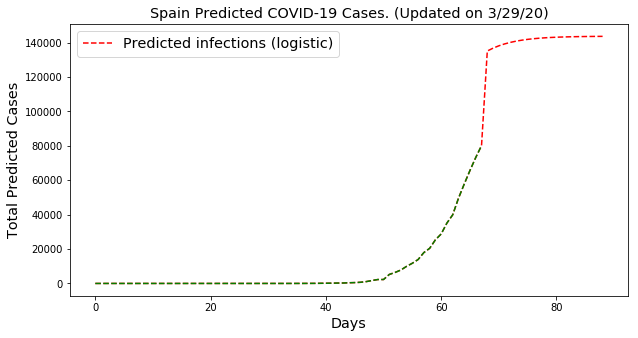



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 62095
	Confirmed cases on 3/22/20 	 24873
	Ratio: 2.5
	Weekly increase: 149.6 %
	Daily increase: 14.0 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9984000711058956
	Doubling Time (during middle of growth):  6.31 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.9921407191926871
	Doubling Time (represents overall growth):  4.58 (± 0.22 ) days


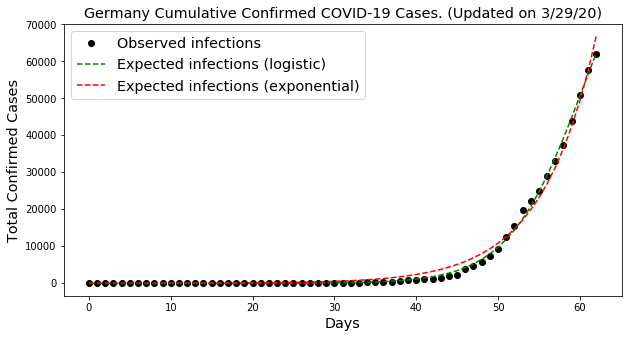

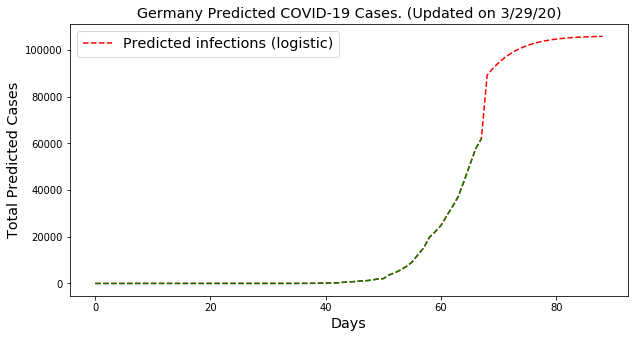

In [132]:
days = len(covid_confirmed.columns)-4 # how many days are in the data file (columns less the first 4)
days_to_model = days+(3*7) # 3 weeks + current number of days

#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
cases = covid_confirmed.iloc[:,[1,-1]].groupby('Country/Region').sum()
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]

topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotCases(covid_confirmed, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3]) 
        plt.figure(figsize=(10,5))
        
        if(len(a[3])==3):
            preds = [exponential(t, a[3][0], a[3][1], a[3][2]) for t in list(range(days,days_to_model,1))] # do pred
            conf = covid_confirmed[covid_confirmed['Country/Region'] == c].iloc[:,4:].values[0].tolist() # get confirmed cases
            allc = conf+preds # append together
            x = list(range(0,days_to_model,1)) 
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted infections (exponential)") # plot predictions
            plt.plot(list(range(0,days,1)),conf,'g--') # plot confirmed cases in green
            
            
        if(len(a[3])==4):
            preds = [logistic(t, a[3][0], a[3][1], a[3][2],a[3][3]) for t in list(range(days,days_to_model,1))]
            conf = covid_confirmed[covid_confirmed['Country/Region'] == c].iloc[:,4:].values[0].tolist()
            allc = conf+preds
            x = list(range(0,days_to_model,1))
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted infections (logistic)")
            plt.plot(list(range(0,days,1)),conf,'g--')
            
    
    plt.title(c + ' Predicted COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Predicted Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    print('\n')

    


# Deaths

In [133]:
def plotDeaths(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Deaths']
    co = co.loc[co['Deaths'] > 0]
    
    y = np.array(co['Deaths'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed deaths on',co.index[-1],'\t',current)
            print('\tConfirmed deaths on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed deaths")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected deaths (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected deaths (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Deaths. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Deaths', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



Italy

** Based on Most Recent Week of Data **

	Confirmed deaths on 3/29/20 	 10779
	Confirmed deaths on 3/22/20 	 5476
	Ratio: 1.97
	Weekly increase: 96.8 %
	Daily increase: 10.2 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9994827149005848
	Doubling Time (during middle of growth):  7.08 (± 0.31 ) days

** Based on Exponential Fit **

	R^2: 0.9875827347589068
	Doubling Time (represents overall growth):  5.36 (± 0.49 ) days


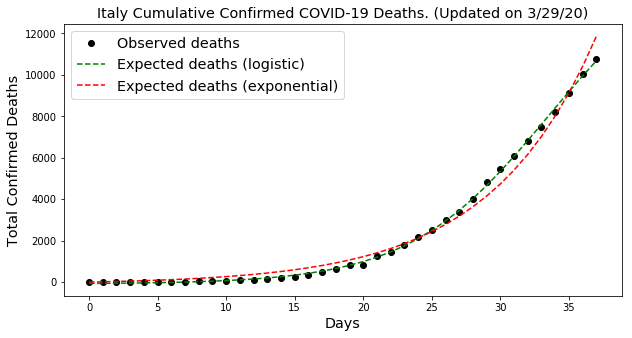

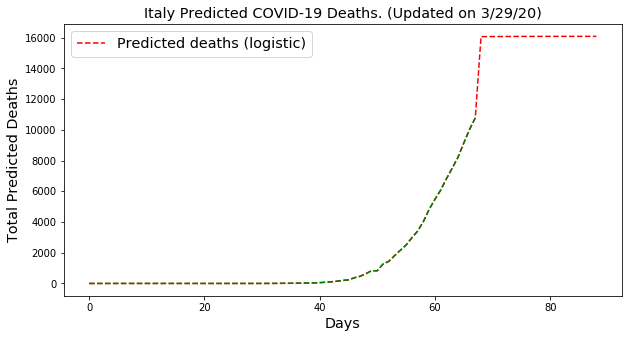



Spain

** Based on Most Recent Week of Data **

	Confirmed deaths on 3/29/20 	 6803
	Confirmed deaths on 3/22/20 	 1772
	Ratio: 3.84
	Weekly increase: 283.9 %
	Daily increase: 21.2 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9997660849255058
	Doubling Time (during middle of growth):  4.68 (± 0.17 ) days

** Based on Exponential Fit **

	R^2: 0.9935784986074992
	Doubling Time (represents overall growth):  3.64 (± 0.28 ) days


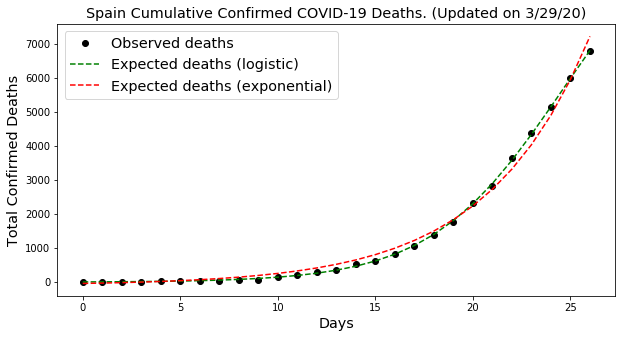

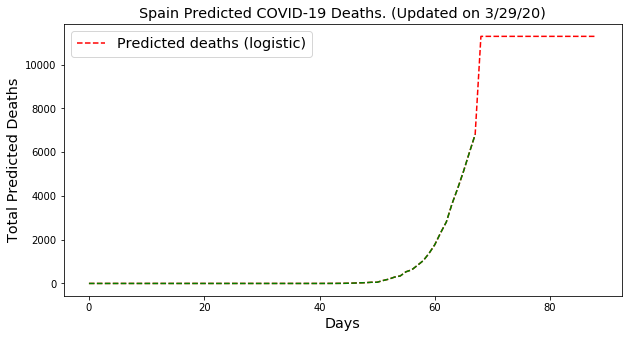



China

** Based on Most Recent Week of Data **

	Confirmed deaths on 3/29/20 	 3304
	Confirmed deaths on 3/22/20 	 3274
	Ratio: 1.01
	Weekly increase: 0.9 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 531.9 days

** Based on Logistic Fit**

	R^2: 0.9992378812035134
	Doubling Time (during middle of growth):  9.86 (± 0.31 ) days


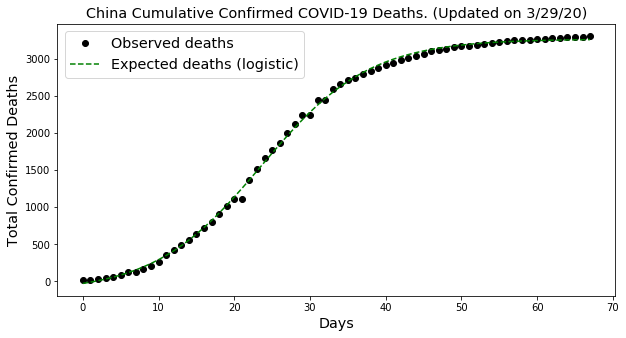

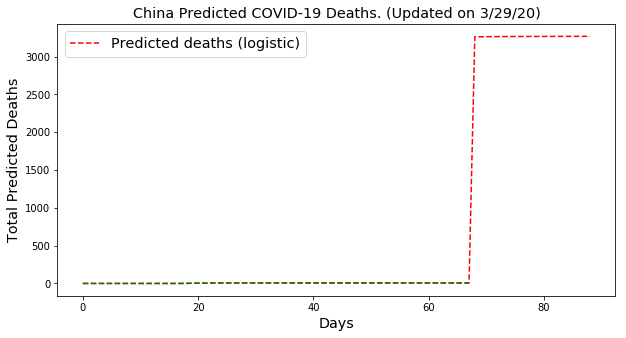



Iran

** Based on Most Recent Week of Data **

	Confirmed deaths on 3/29/20 	 2640
	Confirmed deaths on 3/22/20 	 1685
	Ratio: 1.57
	Weekly increase: 56.7 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.8 days

** Based on Logistic Fit**

	R^2: 0.9991921999918933
	Doubling Time (during middle of growth):  7.19 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.9808075358458902
	Doubling Time (represents overall growth):  7.52 (± 0.96 ) days


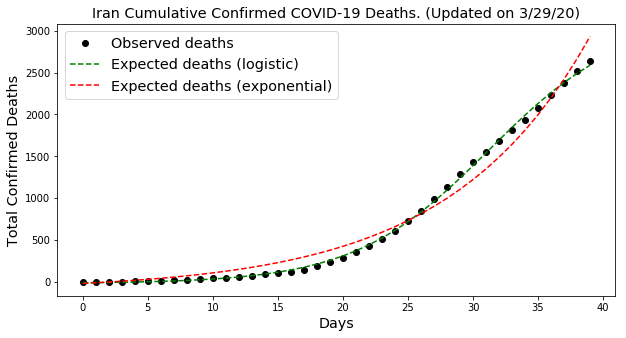

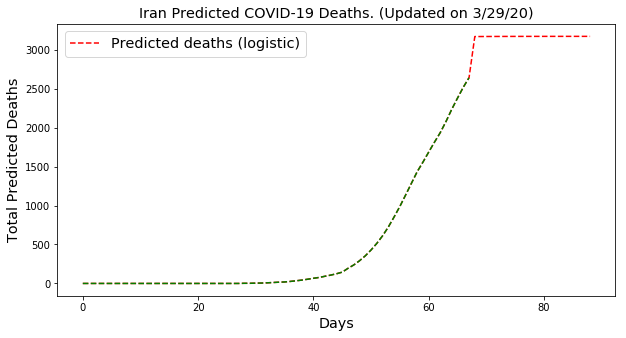



France

** Based on Most Recent Week of Data **

	Confirmed deaths on 3/29/20 	 2611
	Confirmed deaths on 3/22/20 	 676
	Ratio: 3.86
	Weekly increase: 286.2 %
	Daily increase: 21.3 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9990085330078704
	Doubling Time (during middle of growth):  4.43 (± 0.23 ) days

** Based on Exponential Fit **

	R^2: 0.9921461241043984
	Doubling Time (represents overall growth):  3.55 (± 0.2 ) days


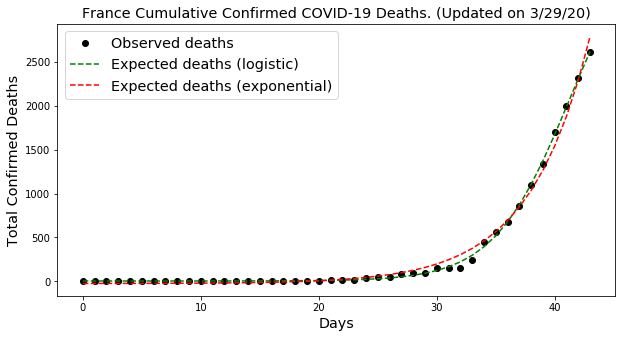

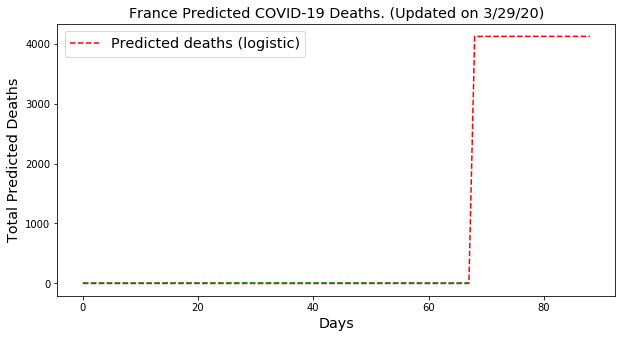

In [134]:
days = len(covid_deaths.columns)-4 # how many days are in the data file (columns less the first 4)
days_to_model = days+(3*7) # 3 weeks + current number of days

#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
deaths = covid_deaths.iloc[:,[1,-1]].groupby('Country/Region').sum()
deaths = deaths.sort_values(by = mostrecentdate, ascending = False)
deaths = deaths[deaths[mostrecentdate] >= 100]

topcountries = deaths.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotDeaths(covid_deaths, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3]) 
        plt.figure(figsize=(10,5))
        
        if(len(a[3])==3):
            preds = [exponential(t, a[3][0], a[3][1], a[3][2]) for t in list(range(days,days_to_model,1))] # do pred
            conf = covid_deaths[covid_deaths['Country/Region'] == c].iloc[:,4:].values[0].tolist() # get confirmed cases
            allc = conf+preds # append together
            x = list(range(0,days_to_model,1)) 
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted deaths (exponential)") # plot predictions
            plt.plot(list(range(0,days,1)),conf,'g--') # plot confirmed cases in green
            
            
        if(len(a[3])==4):
            preds = [logistic(t, a[3][0], a[3][1], a[3][2],a[3][3]) for t in list(range(days,days_to_model,1))]
            conf = covid_deaths[covid_deaths['Country/Region'] == c].iloc[:,4:].values[0].tolist()
            allc = conf+preds
            x = list(range(0,days_to_model,1))
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted deaths (logistic)")
            plt.plot(list(range(0,days,1)),conf,'g--')
            
    
    plt.title(c + ' Predicted COVID-19 Deaths. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Predicted Deaths', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    print('\n')

    


# Recovery

In [135]:
def plotRecovered(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Recovered']
    co = co.loc[co['Recovered'] > 0]
    
    y = np.array(co['Recovered'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed recovered on',co.index[-1],'\t',current)
            print('\tConfirmed recovered on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed recovered")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected recovered (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected recovered (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Recovered. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Recovered', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed recovered on 3/29/20 	 75582
	Confirmed recovered on 3/22/20 	 72362
	Ratio: 1.04
	Weekly increase: 4.4 %
	Daily increase: 0.6 % per day
	Doubling Time (represents recent growth): 111.4 days

** Based on Logistic Fit**

	R^2: 0.9995008599429428
	Doubling Time (during middle of growth):  10.16 (± 0.26 ) days


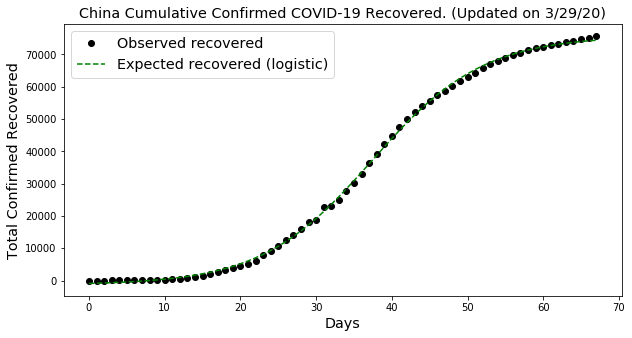

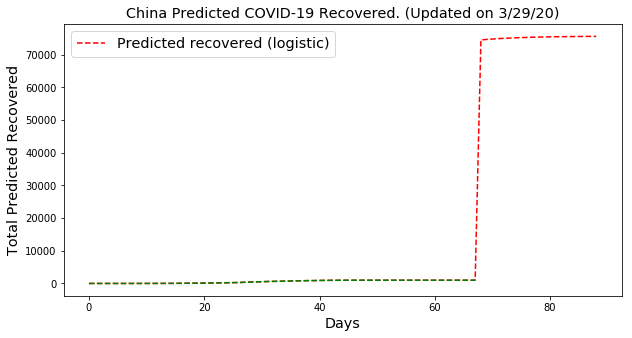



Spain

** Based on Most Recent Week of Data **

	Confirmed recovered on 3/29/20 	 14709
	Confirmed recovered on 3/22/20 	 2575
	Ratio: 5.71
	Weekly increase: 471.2 %
	Daily increase: 28.3 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.9968647325130547
	Doubling Time (represents overall growth):  2.7 (± 0.1 ) days


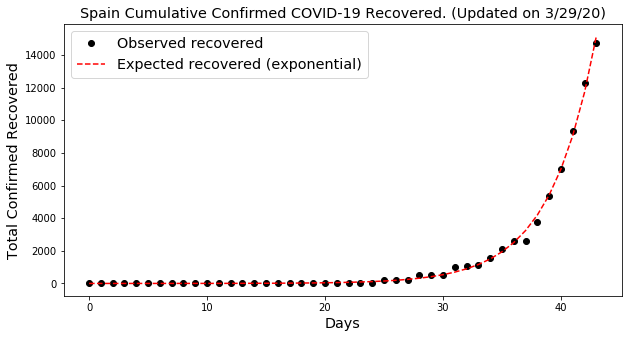

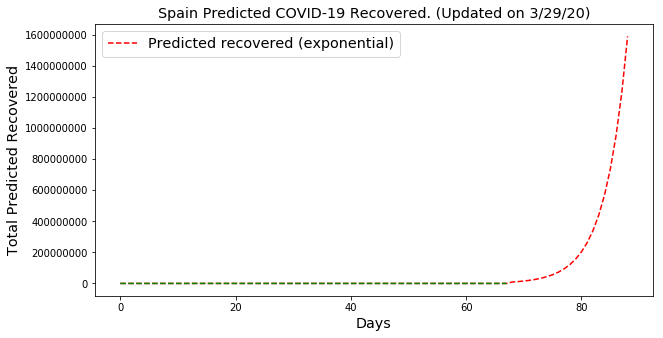



Italy

** Based on Most Recent Week of Data **

	Confirmed recovered on 3/29/20 	 13030
	Confirmed recovered on 3/22/20 	 7024
	Ratio: 1.86
	Weekly increase: 85.5 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9977492564545467
	Doubling Time (during middle of growth):  7.25 (± 0.69 ) days

** Based on Exponential Fit **

	R^2: 0.9801468994970632
	Doubling Time (represents overall growth):  5.0 (± 0.57 ) days


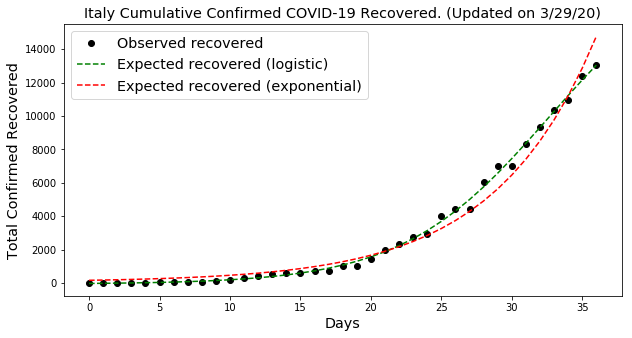

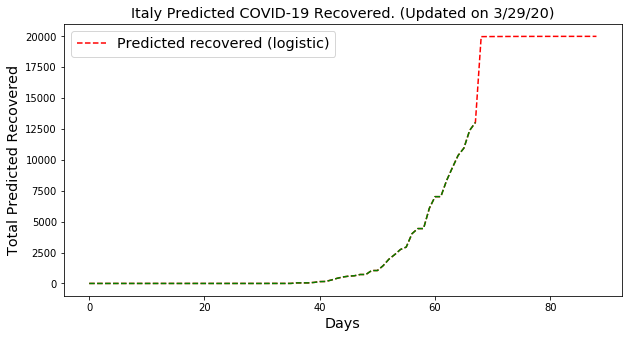



Iran

** Based on Most Recent Week of Data **

	Confirmed recovered on 3/29/20 	 12391
	Confirmed recovered on 3/22/20 	 7931
	Ratio: 1.56
	Weekly increase: 56.2 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.9 days

** Based on Logistic Fit**

	R^2: 0.9941585574020836
	Doubling Time (during middle of growth):  14.68 (± 5.31 ) days


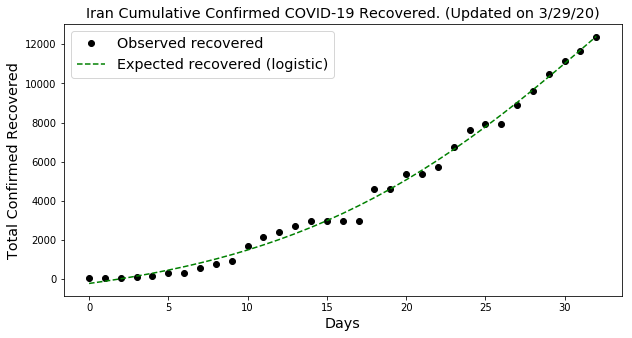

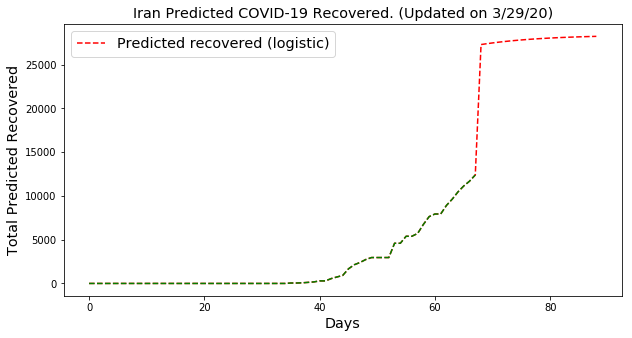



Germany

** Based on Most Recent Week of Data **

	Confirmed recovered on 3/29/20 	 9211
	Confirmed recovered on 3/22/20 	 266
	Ratio: 34.63
	Weekly increase: 3362.8 %
	Daily increase: 65.9 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Exponential Fit **

	R^2: 0.9559659596285127
	Doubling Time (represents overall growth):  2.45 (± 0.32 ) days


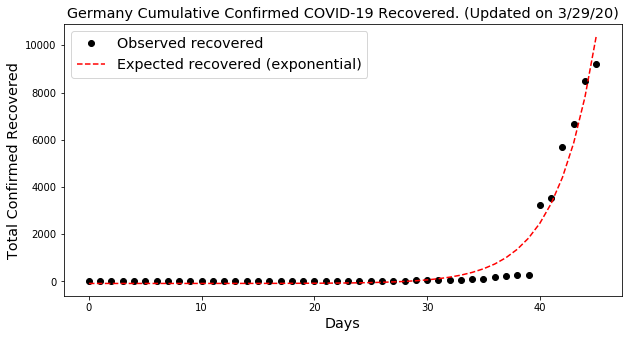

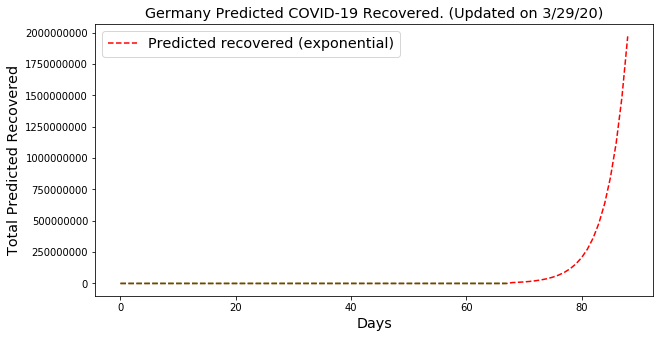

In [136]:
days = len(covid_recovered.columns)-4 # how many days are in the data file (columns less the first 4)
days_to_model = days+(3*7) # 3 weeks + current number of days

#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
recovered = covid_recovered.iloc[:,[1,-1]].groupby('Country/Region').sum()
recovered = recovered.sort_values(by = mostrecentdate, ascending = False)
recovered = recovered[recovered[mostrecentdate] >= 100]

topcountries = recovered.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotRecovered(covid_recovered, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3]) 
        plt.figure(figsize=(10,5))
        
        if(len(a[3])==3):
            preds = [exponential(t, a[3][0], a[3][1], a[3][2]) for t in list(range(days,days_to_model,1))] # do pred
            conf = covid_recovered[covid_recovered['Country/Region'] == c].iloc[:,4:].values[0].tolist() # get confirmed cases
            allc = conf+preds # append together
            x = list(range(0,days_to_model,1)) 
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted recovered (exponential)") # plot predictions
            plt.plot(list(range(0,days,1)),conf,'g--') # plot confirmed cases in green
            
            
        if(len(a[3])==4):
            preds = [logistic(t, a[3][0], a[3][1], a[3][2],a[3][3]) for t in list(range(days,days_to_model,1))]
            conf = covid_recovered[covid_recovered['Country/Region'] == c].iloc[:,4:].values[0].tolist()
            allc = conf+preds
            x = list(range(0,days_to_model,1))
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted recovered (logistic)")
            plt.plot(list(range(0,days,1)),conf,'g--')
            
    
    plt.title(c + ' Predicted COVID-19 Recovered. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Predicted Recovered', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    print('\n')

    


# Testing predictions on left-out data

In [137]:
def plotCasesLO(dataframe, column, country, days):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed infections")
    
    logisticworked = False
    exponentialworked = False
    
    # same as before, but we hold out days
    
    print('\nLeaving out:',days,'days')
    y_lo = y[:-days] # hold out x days from the data
    x_lo = np.arange(y_lo.size)

    try:
        lpopt, lpcov = curve_fit(logistic, x_lo, y_lo, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y_lo - logistic(x_lo, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_lo - np.mean(y_lo))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        print(logisticr2)
        if logisticr2 > 0.95:
            plt.plot(x_lo, logistic(x_lo, *lpopt), 'g--', label="Expected infections (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
            
            # now we apply the model to the final x days and check the accuracy
            test_days = list(range(max(x_lo),max(x),1))
            preds = [logistic(t, lpopt[0], lpopt[1], lpopt[2],lpopt[3]) for t in test_days]
            preds = np.asarray(preds)

            test_set_residuals = y[len(y) - days:] - preds
            ss_res_test = np.sum(test_set_residuals**2)
            ss_tot_test = np.sum((y[len(y) - days:] - np.mean(y[len(y) - days:]))**2)
            logisticr2test = 1 - (ss_res_test/ss_tot_test)

           
            plt.plot(test_days,preds,'b--',label="Applied to held-out data (logistic)")
            print('\tR^2 (test set):', logisticr2test)
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x_lo, y_lo, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y_lo - exponential(x_lo, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_lo - np.mean(y_lo))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x_lo, exponential(x_lo, *epopt), 'r--', label="Expected infections (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            test_days = list(range(max(x_lo),max(x),1))
            preds = [exponential(t, epopt[0], epopt[1], epopt[2]) for t in test_days]
            preds = np.asarray(preds)

            test_set_residuals = y[len(y) - days:] - preds
            ss_res_test = np.sum(test_set_residuals**2)
            ss_tot_test = np.sum((y[len(y) - days:] - np.mean(y[len(y) - days:]))**2)
            expr2test = 1 - (ss_res_test/ss_tot_test)

            
            plt.plot(test_days,preds,'c--',label="Applied to held-out data (exponential)")
            print('\tR^2 (test set):', expr2test)
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt]
    
    else:
        print("Modelling failed to produce accurate (>0.95) results")
        return [float('NaN'), float('NaN'), recentdbltime,float('NaN')]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 140886
	Confirmed cases on 3/22/20 	 33276
	Ratio: 4.23
	Weekly increase: 323.4 %
	Daily increase: 22.9 % per day
	Doubling Time (represents recent growth): 3.4 days

Leaving out: 3 days

** Based on Exponential Fit **

	R^2: 0.996424749907336
	Doubling Time (represents overall growth):  2.74 (± 0.08 ) days
	R^2 (test set): 0.5199707943474567


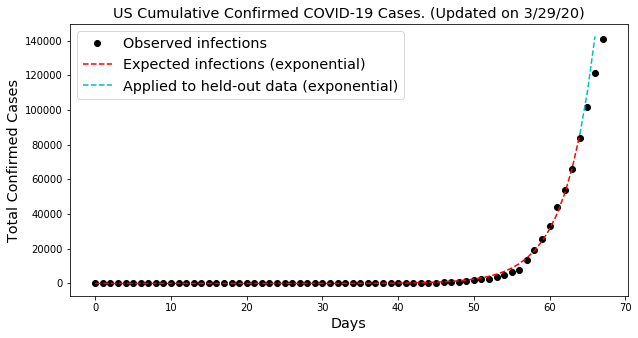



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 97689
	Confirmed cases on 3/22/20 	 59138
	Ratio: 1.65
	Weekly increase: 65.2 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

Leaving out: 3 days
0.9995564258991256

** Based on Logistic Fit**

	R^2: 0.9995564258991256
	Doubling Time (during middle of growth):  7.11 (± 0.22 ) days
	R^2 (test set): -1.7998109294725069

** Based on Exponential Fit **

	R^2: 0.9883617006068174
	Doubling Time (represents overall growth):  5.62 (± 0.36 ) days
	R^2 (test set): -4.031051268564574


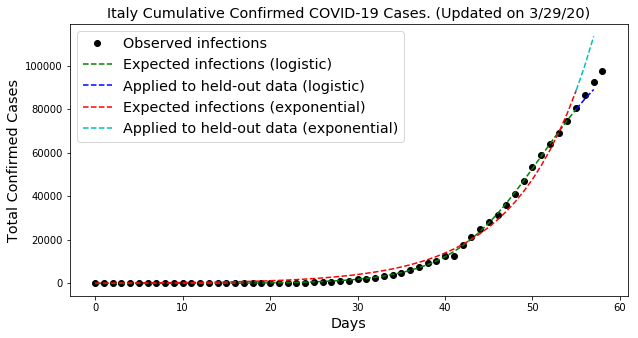



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 82122
	Confirmed cases on 3/22/20 	 81435
	Ratio: 1.01
	Weekly increase: 0.8 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 577.6 days

Leaving out: 3 days
0.9956339285088128

** Based on Logistic Fit**

	R^2: 0.9956339285088128
	Doubling Time (during middle of growth):  6.49 (± 0.5 ) days
	R^2 (test set): -84.13156091033825


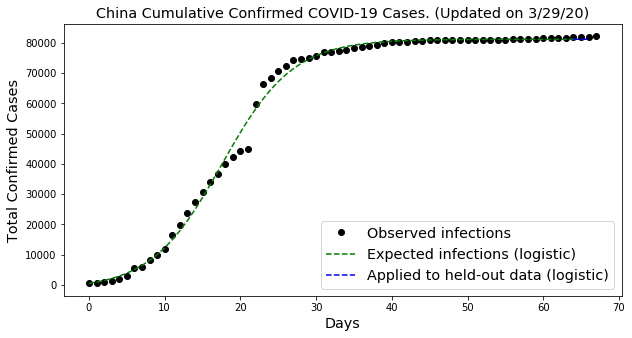



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 80110
	Confirmed cases on 3/22/20 	 28768
	Ratio: 2.78
	Weekly increase: 178.5 %
	Daily increase: 15.8 % per day
	Doubling Time (represents recent growth): 4.7 days

Leaving out: 3 days

** Based on Exponential Fit **

	R^2: 0.9968665075374075
	Doubling Time (represents overall growth):  3.81 (± 0.12 ) days
	R^2 (test set): 0.2806652813133408


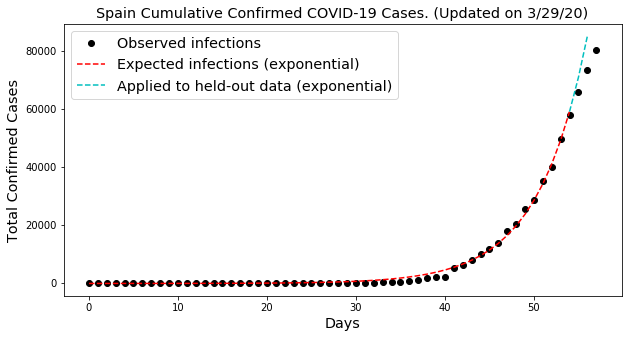



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 62095
	Confirmed cases on 3/22/20 	 24873
	Ratio: 2.5
	Weekly increase: 149.6 %
	Daily increase: 14.0 % per day
	Doubling Time (represents recent growth): 5.3 days

Leaving out: 3 days
0.9981854374725514

** Based on Logistic Fit**

	R^2: 0.9981854374725514
	Doubling Time (during middle of growth):  5.35 (± 0.32 ) days
	R^2 (test set): -4.477331246699528

** Based on Exponential Fit **

	R^2: 0.9912044673608964
	Doubling Time (represents overall growth):  4.11 (± 0.21 ) days
	R^2 (test set): 0.3523020798649038


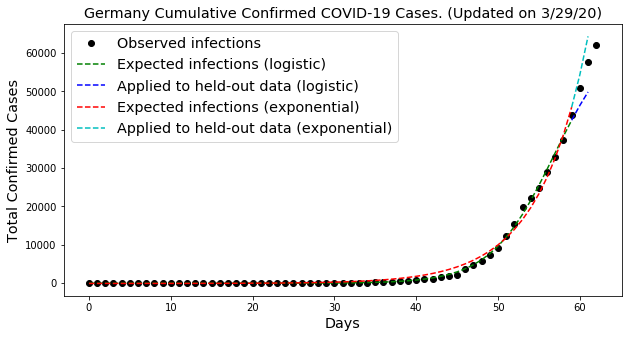

In [138]:
#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
cases = covid_confirmed.iloc[:,[1,-1]].groupby('Country/Region').sum()
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]

topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotCasesLO(covid_confirmed, 'Country/Region', c,3)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3])
    print('\n')

    

# Create plots for slides, and dict for front end
Modification of plotCases function to make and plot predictions

In [173]:
def plotCasesandPredict(dataframe, column, country,days):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed infections")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            
            # show curve fit
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected infections (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
            
            # make predictions
            day_now = y.size-1 # what day we are on now
            future_day = day_now + days # how many days in the future we are predicting
            
            preds_log = [logistic(t,lpopt[0],lpopt[1],lpopt[2],lpopt[3]) for t in list(range(day_now,future_day,1))] # do pred
            x_log = list(range(day_now,future_day,1))
            y_log = preds_log
            plt.ticklabel_format(style = 'plain')
            plt.plot(x_log, y_log, 'y--', label="Predicted infections (logistic)") # plot predictions
            
            print('\n** Predicting day', future_day,'(',days,'days time)**\n')
            print('\tPredicted number of infections (logistic growth):',round(preds_log[-1]))
    
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected infections (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
            # make predictions
            day_now = y.size-1 # what day we are on now
            future_day = day_now + days # how many days in the future we are predicting
            
            preds_exp = [exponential(t,epopt[0],epopt[1],epopt[2]) for t in list(range(day_now,future_day,1))] # do pred
            x_exp = list(range(day_now,future_day,1))
            y_exp = preds_exp
            plt.ticklabel_format(style = 'plain')
            plt.plot(x_exp, y_exp, 'b--', label="Predicted infections (exponential)") # plot predictions
            
            print('\n** Predicting day', future_day,'(',days,'days time)**\n')
            print('\tPredicted number of infections (exponential growth):',round(preds_exp[-1]))
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt,round(preds_log[-1])]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt,round(preds_exp[-1])]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt,round(preds_log[-1])]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt,round(preds_exp[-1])]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime,float('NaN'),float('NaN')]

Do the plots and make the dict

dict in form:
{
  "results":[
    {
      "country_code": "IT",
      "country_name": "Italy",
      "resources_capacity": "39000",
      "confirmed": "40000",
      "deaths": "3000",
      "recovered": "800",
      "confirmed_prediction_3w": "50000",
      "deaths_prediction_3w": "4000",
      "recovered_prediction_3w": "900"
    },
    {
      "country_code": "ES",
      "country_name": "Spain",
      "resources_capacity": "40000",
      "confirmed": "30000",
      "deaths": "2500",
      "recovered": "600",
      "confirmed_prediction_3w": "60000",
      "deaths_prediction_3w": "2800",
      "recovered_prediction_3w": "1200"
      }
   ],
   "timestamp": "2020-03-29 17:05:51.514470"
}



** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 97689
	Confirmed cases on 3/22/20 	 59138
	Ratio: 1.65
	Weekly increase: 65.2 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.9995874128650082
	Doubling Time (during middle of growth):  7.51 (± 0.21 ) days

** Predicting day 79 ( 21 days time)**

	Predicted number of infections (logistic growth): 127742.0

** Based on Exponential Fit **

	R^2: 0.9772435771875994
	Doubling Time (represents overall growth):  5.71 (± 0.5 ) days

** Predicting day 79 ( 21 days time)**

	Predicted number of infections (exponential growth): 1285270.0


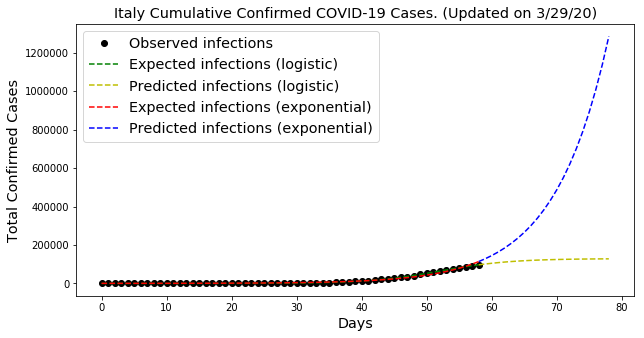


** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 140886
	Confirmed cases on 3/22/20 	 33276
	Ratio: 4.23
	Weekly increase: 323.4 %
	Daily increase: 22.9 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.9947601247636948
	Doubling Time (represents overall growth):  3.23 (± 0.12 ) days

** Predicting day 88 ( 21 days time)**

	Predicted number of infections (exponential growth): 10916370.0


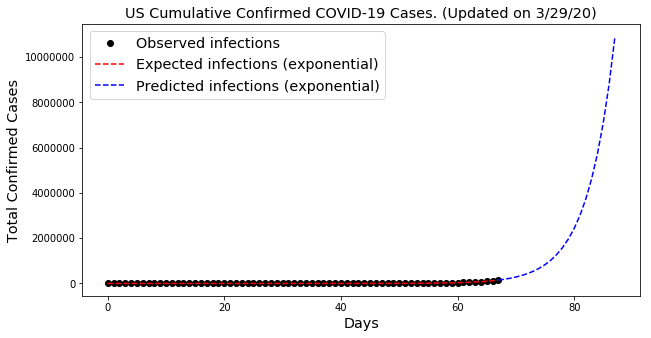


** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 14829
	Confirmed cases on 3/22/20 	 7474
	Ratio: 1.98
	Weekly increase: 98.4 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9989720273419039
	Doubling Time (during middle of growth):  5.17 (± 0.3 ) days

** Predicting day 54 ( 21 days time)**

	Predicted number of infections (logistic growth): 17895.0

** Based on Exponential Fit **

	R^2: 0.9650847304231174
	Doubling Time (represents overall growth):  4.43 (± 0.7 ) days

** Predicting day 54 ( 21 days time)**

	Predicted number of infections (exponential growth): 396680.0


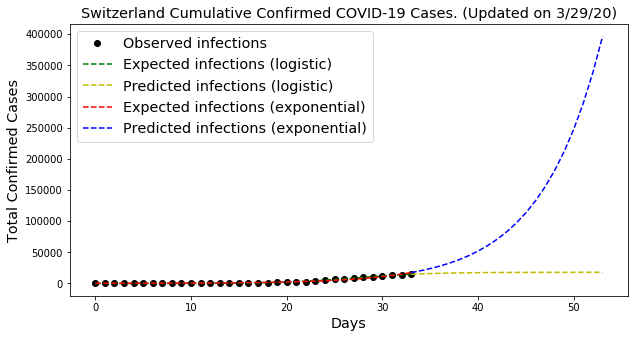


** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 38309
	Confirmed cases on 3/22/20 	 21638
	Ratio: 1.77
	Weekly increase: 77.0 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.9943009719855942
	Doubling Time (during middle of growth):  19.35 (± 7.3 ) days

** Predicting day 60 ( 21 days time)**

	Predicted number of infections (logistic growth): 106469.0


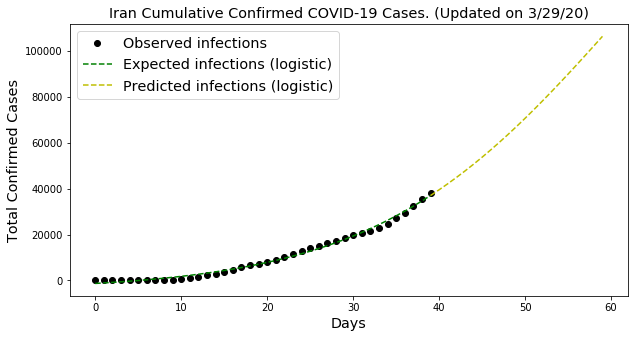


** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 19780
	Confirmed cases on 3/22/20 	 5745
	Ratio: 3.44
	Weekly increase: 244.3 %
	Daily increase: 19.3 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Exponential Fit **

	R^2: 0.998154682372955
	Doubling Time (represents overall growth):  3.76 (± 0.09 ) days

** Predicting day 79 ( 21 days time)**

	Predicted number of infections (exponential growth): 818789.0


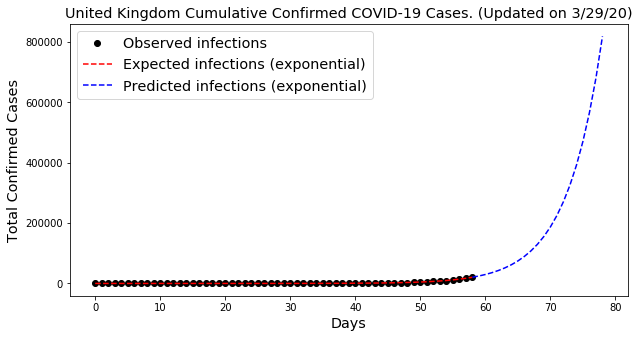


** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 62095
	Confirmed cases on 3/22/20 	 24873
	Ratio: 2.5
	Weekly increase: 149.6 %
	Daily increase: 14.0 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9984000711058956
	Doubling Time (during middle of growth):  6.31 (± 0.35 ) days

** Predicting day 83 ( 21 days time)**

	Predicted number of infections (logistic growth): 105218.0

** Based on Exponential Fit **

	R^2: 0.9921407191926871
	Doubling Time (represents overall growth):  4.58 (± 0.22 ) days

** Predicting day 83 ( 21 days time)**

	Predicted number of infections (exponential growth): 1380551.0


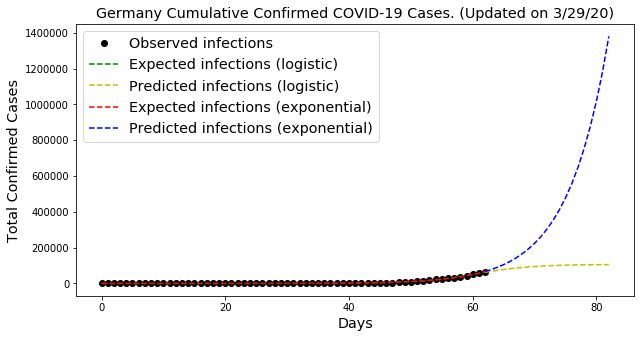


** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 80110
	Confirmed cases on 3/22/20 	 28768
	Ratio: 2.78
	Weekly increase: 178.5 %
	Daily increase: 15.8 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9991540535019782
	Doubling Time (during middle of growth):  6.11 (± 0.26 ) days

** Predicting day 78 ( 21 days time)**

	Predicted number of infections (logistic growth): 142543.0

** Based on Exponential Fit **

	R^2: 0.9933537032704164
	Doubling Time (represents overall growth):  4.37 (± 0.2 ) days

** Predicting day 78 ( 21 days time)**

	Predicted number of infections (exponential growth): 2064834.0


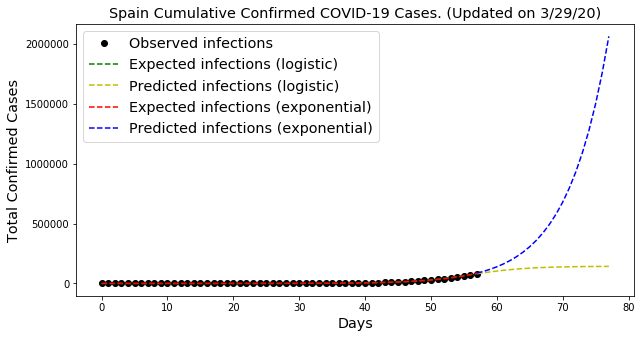

In [174]:
countries = ['Italy','US','Switzerland','Iran','United Kingdom','Germany','Spain']
dataframe = covid_confirmed
column = "Country/Region"
days = 21
from datetime import datetime
timestamp = datetime.now()

results = {"results":[],"timestamp":timestamp}
results_keys = ['country_code','country_name','resources_capacity','confirmed','deaths','recovered','confirmed_prediction_3w','deaths_prediction_3w','recovered_prediction_3w']

for c in countries:
    # run
    dbltime,dbltimeerr,recentdbltime,params,pred = plotCasesandPredict(dataframe,column,c,days)
    
    # initialise dict of results
    results_dict = dict.fromkeys(results_keys)
    
    # generate dict values
    country_code = "TEST" # add later
    country_name = c
    resources_capacity = "TEST" #???
    confirmed = int(dataframe[dataframe['Country/Region']==c].iloc[:,-1].sum())
    deaths = int(covid_deaths[covid_deaths['Country/Region']==c].iloc[:,-1].sum())
    recovered = int(covid_recovered[covid_recovered['Country/Region']==c].iloc[:,-1].sum())
    confirmed_prediction_3w = int(pred) # we take the prediction
    deaths_prediction_3w = int(deaths/confirmed * confirmed_prediction_3w) # use current perc deaths
    recovered_prediction_3w = int(recovered/confirmed * confirmed_prediction_3w) # use current perc recovered
    
    # populate dict
    results_dict['country_code'] = country_code
    results_dict['country_name'] = country_name
    results_dict['resources_capacity'] = resources_capacity
    results_dict['confirmed'] = confirmed
    results_dict['deaths'] = deaths
    results_dict['recovered'] = recovered
    results_dict['confirmed_prediction_3w'] = confirmed_prediction_3w
    results_dict['deaths_prediction_3w'] = deaths_prediction_3w
    results_dict['recovered_prediction_3w'] = recovered_prediction_3w
    
    # append to master dict
    results['results'].append(results_dict)
    
    
    
    

In [166]:
results

{'results': [{'country_code': 'TEST',
   'country_name': 'Italy',
   'resources_capacity': 'TEST',
   'confirmed': 97689,
   'deaths': 10779,
   'recovered': 13030,
   'confirmed_prediction_3w': 127742,
   'deaths_prediction_3w': 14095,
   'recovered_prediction_3w': 17038},
  {'country_code': 'TEST',
   'country_name': 'US',
   'resources_capacity': 'TEST',
   'confirmed': 140886,
   'deaths': 2467,
   'recovered': 2665,
   'confirmed_prediction_3w': 10916370,
   'deaths_prediction_3w': 191152,
   'recovered_prediction_3w': 206494},
  {'country_code': 'TEST',
   'country_name': 'Switzerland',
   'resources_capacity': 'TEST',
   'confirmed': 14829,
   'deaths': 300,
   'recovered': 1595,
   'confirmed_prediction_3w': 17895,
   'deaths_prediction_3w': 362,
   'recovered_prediction_3w': 1924},
  {'country_code': 'TEST',
   'country_name': 'Iran',
   'resources_capacity': 'TEST',
   'confirmed': 38309,
   'deaths': 2640,
   'recovered': 12391,
   'confirmed_prediction_3w': 106469,
   'deat

In [163]:
dataframe[dataframe['Country/Region']==c]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
217,Bermuda,United Kingdom,32.3078,-64.7505,0,0,0,0,0,0,...,2,2,6,6,6,7,15,17,17,22
218,Cayman Islands,United Kingdom,19.3133,-81.2546,0,0,0,0,0,0,...,3,3,3,5,6,8,8,8,8,8
219,Channel Islands,United Kingdom,49.3723,-2.3644,0,0,0,0,0,0,...,14,32,32,36,36,46,66,88,97,108
220,Gibraltar,United Kingdom,36.1408,-5.3536,0,0,0,0,0,0,...,10,10,15,15,15,26,35,55,56,65
221,Isle of Man,United Kingdom,54.2361,-4.5481,0,0,0,0,0,0,...,1,1,5,13,23,23,25,29,32,42
222,Montserrat,United Kingdom,16.7425,-62.1874,0,0,0,0,0,0,...,1,1,1,1,1,1,5,5,5,5
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,3983,5018,5683,6650,8077,9529,11658,14543,17089,19522
249,Anguilla,United Kingdom,18.2206,-63.0686,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
250,British Virgin Islands,United Kingdom,18.4207,-64.6400,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
251,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,4
